# **GUITAR TUNER**

*   Mykola Liashuha
*   Jose Gonzalez Lopez


## INTRODUCTION
In this work, we present an spectral analysis on 3 different audio files with the main ofjective to identify the major note that was played in each audio. First, all audio files were read and explored by using simple functions such as ploting the output of aduio signals and fourier transform outputs. Then, we applied our algorithm in order to automatically identify the main note that is in the audio. There were a few bottlenecks with harmonic notes and additional peaks that we overcame, and those issues are explined further in the notebook

Additionally, as further proof with the use of the librosa library we could map elements such as the chroma feature of the signals. 

Last, we will discuss the results and wrap up the notebook.

## IMPORTS

In [1]:
#Imports
import numpy as np
import sklearn #Use this library to normalize
import math #For calculations
import scipy.signal #For signals
from scipy.io import wavfile #Read wav files
from matplotlib import pyplot as plt #Plots
from scipy.fft import fft, ifft,fftfreq #Fourier transform


## AUXILIAR FUNCTIONS

In [2]:
'''
Transform all frecuencies into the corresponding notes given in result
'''
def filter(results):
    notes = []
    for r in results:
        if r < 335 and r > 325:
            notes.append("Got E1")
        if r < 251 and r > 240:
            notes.append("Got B2")
        if r < 201 and r > 190:
            notes.append("Got G3")
        if r < 150 and r > 140:
            notes.append("Got D4")
        if r < 115 and r > 105:
            notes.append("Got A5")
        if r < 87 and r > 78:
            notes.append("Got E6")

    return np.unique(notes).tolist()

In [3]:
'''
Given a range of frequencies (x) and its values (y), this function:
- finds the highet peaks of the data
- finds the start/end of each peak
- calculate the areas under each peak with regard to their start and end
- return peak with highest area under it
'''

def get_highest_freqs(x, y,threshold=15000000):
    y = np.abs(y)
    res = []
    for i in range(len(x)):
        if y[i] > threshold: #This is arbitrary
            res.append(x[i])
    prod = []
    

    for r in res:
        out = get_impulse_range(x, y, r)
        area = 0
        for i in range(out[0], out[1]):
            dif = x[i+1]-x[i]
            tmp = (abs(y[i+1] - y[i])/2)*dif
            area += tmp
#         print(r, xf_1[out[0]], xf_1[out[1]], area) 
        prod.append((r, area))
    prod = sorted(prod, key=lambda k: k[1])
#     print(prod)
    best = prod[-1][0]
    return [best]

In [4]:
'''
With regard to frequencies (x) and their values (y), and the position of peak
-> We compute the begginig and end of the peak. The output of this function is used to calcualte t
he area under this range
'''
def get_impulse_range(x, y, point):
    ind = [i for i, val in enumerate(x) if val == point][0]
    pick_y = y[ind]
    prev = pick_y
    start = ind
    end = ind
    
    cnst = 70000
    
    step = 20
    
    while True:
        start = start - step
        dd = np.abs(prev) - np.abs(y[start]) 
        if dd < cnst:
            start = start + step
            break
        else:
            prev = y[start]
            
    prev = pick_y
    while True:
        end = end + step
        dd = np.abs(prev) - np.abs(y[end])
        if dd < cnst:
            end = end - step
            break
        else:
            prev = y[end]
    return start, end

## Data exploration
In the following section we present the basic analysis of each of the 3 audio files

In [5]:
#Read files
sr_1, data_1 = wavfile.read('string_1.wav')
sr_2, data_2 = wavfile.read('string_2.wav')
sr_3, data_3 = wavfile.read('string_3.wav')

In [6]:
# Sample rate exploration
print(sr_1)
print(sr_2)
print(sr_3)

44100
22050
22050


With this simple prints, we know that the first audio signal has a samplig rate of 44.1 KHZ and the other 2 have 22KHZ

In [7]:
#Data exploration
print(data_1.shape)
print(data_2.shape)
print(data_3.shape)

(237568,)
(117912,)
(124344,)


Not all the audios have the same data. Time to plot them and see the wave signal physically.

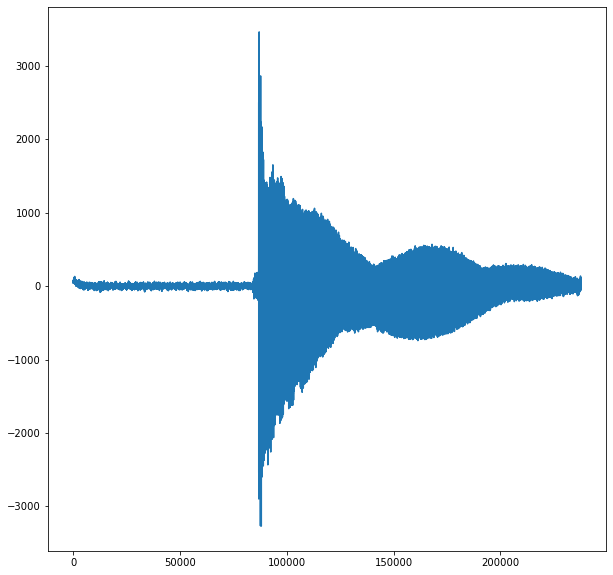

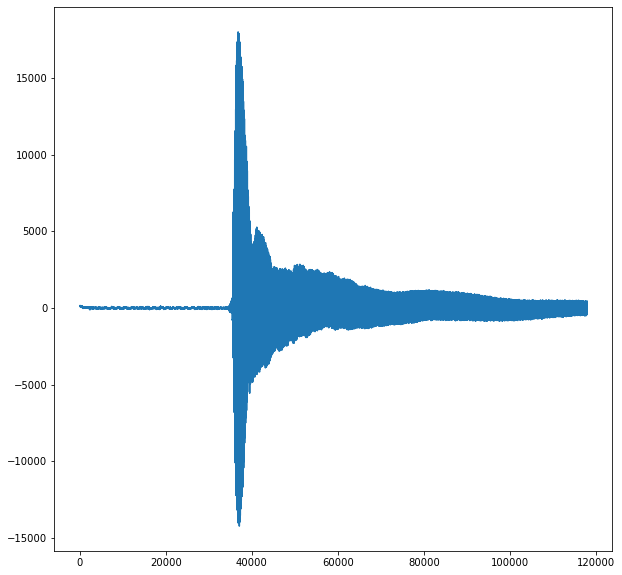

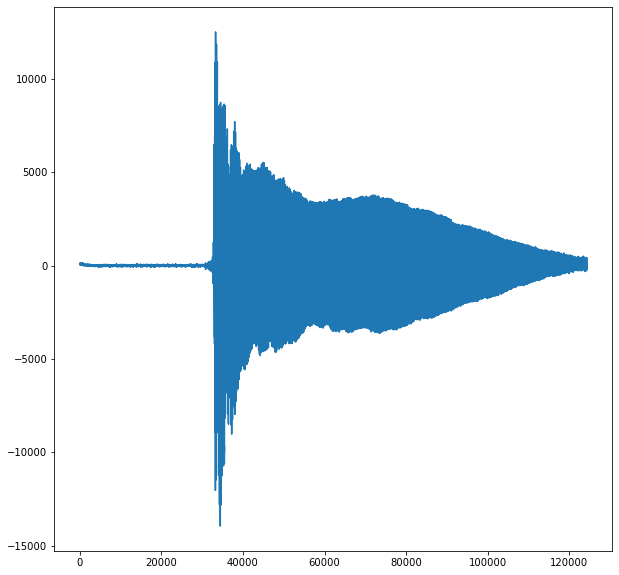

In [8]:
#Plot the string wave
plt.figure(figsize=(10,10))
plt.plot(data_1)
plt.figure(figsize=(10,10))
plt.plot(data_2)
plt.figure(figsize=(10,10))
plt.plot(data_3)

## Note analysis
In this section we will provide the notes of each audio file and justify our findings.

### Fourier transform
Let's get the fourier transform of each file. We see on *x* the range of different of frequencies. And *y* shows us how much we hear this particular frequency.

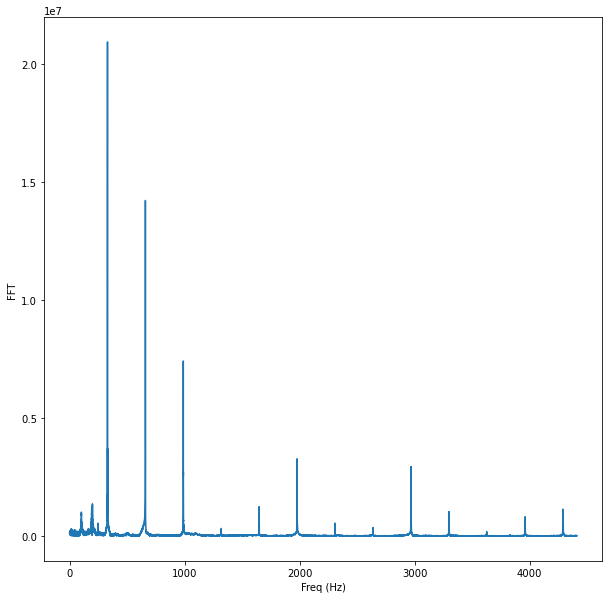

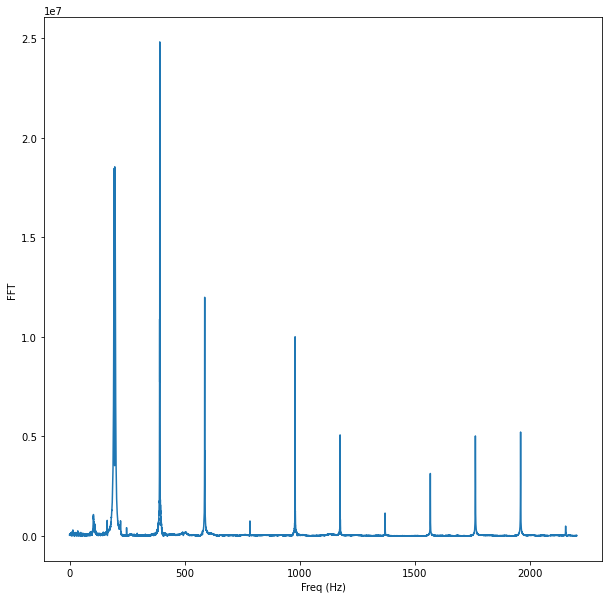

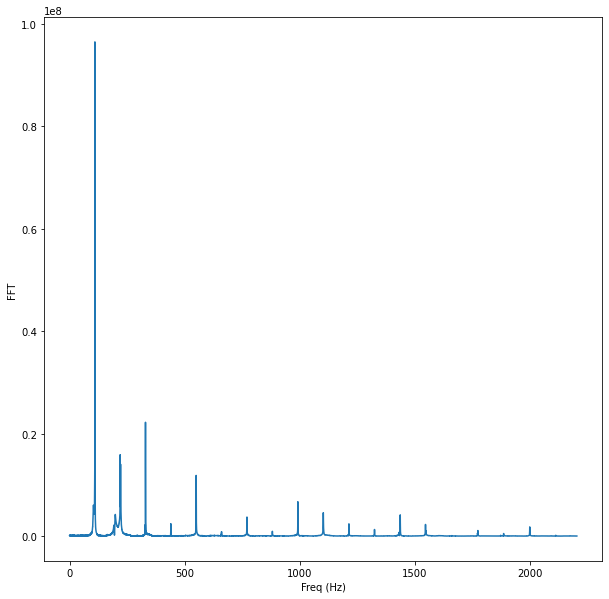

In [9]:
#Prepare to plot fourier transform and get peaks
#Audio 1
N = data_1.shape[0]
# sample spacing
T = 1.0 / sr_1
#Transform
yf_1 = fft(data_1)
xf_1 = fftfreq(N, T)[:N//10]
#And plot
plt.figure(figsize=(10,10))
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT')
plt.plot(xf_1, np.abs(yf_1)[:N//10])
plt.show()

#Audio 2
N = data_2.shape[0]
# sample spacing
T = 1.0 / sr_2
#Transform
yf_2 = fft(data_2)
xf_2 = fftfreq(N, T)[:N//10]
#And plot
plt.figure(figsize=(10,10))
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT')
plt.plot(xf_2, np.abs(yf_2)[:N//10])
plt.show()

#Audio 3
N = data_3.shape[0]
# sample spacing
T = 1.0 / sr_3
#Transform
yf_3 = fft(data_3)
xf_3 = fftfreq(N, T)[:N//10]
#And plot
plt.figure(figsize=(10,10))
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT')
plt.plot(xf_3, np.abs(yf_3)[:N//10])
plt.show()

As you see the first plot is quite easy to understand: there we have the obvious peak that corresponds to the correct note.

But in the second case, the highest peak is not the note that is ringing in the sound. 

Third case is also a bit complicated since it has also a few peaks.

That's why in order to ovecome these issues we introduced the analysis of not the peaks themself. But we actually measure the area under the peaks (from the point when peak starts to elevate to the point when it stops falling).

Let's zoom in the 2nd, 3rd plots and see how they look around the right note.

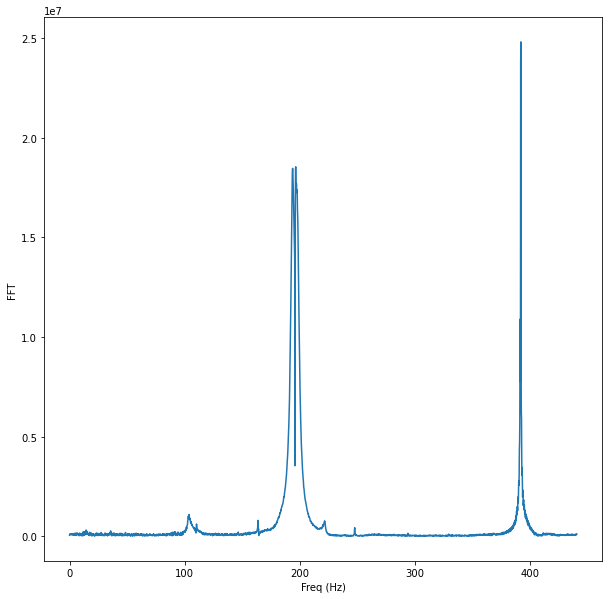

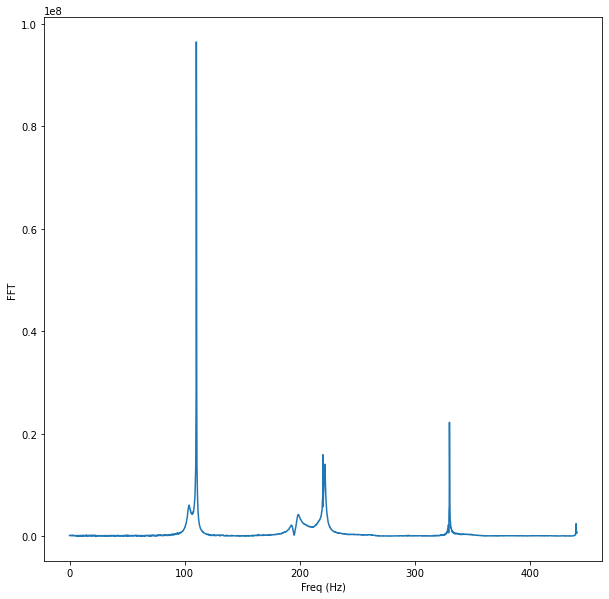

In [10]:
#Audio 2 zoomed in
N = data_2.shape[0]
# sample spacing
T = 1.0 / sr_2
#Transform
yf_2 = fft(data_2)
xf_2_c = fftfreq(N, T)[:N//50]
#And plot
plt.figure(figsize=(10,10))
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT')
plt.plot(xf_2_c, np.abs(yf_2)[:N//50])
plt.show()

#Audio 3 zoomed in
N = data_3.shape[0]
# sample spacing
T = 1.0 / sr_3
#Transform
yf_3 = fft(data_3)
xf_3_c = fftfreq(N, T)[:N//50]
#And plot
plt.figure(figsize=(10,10))
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT')
plt.plot(xf_3_c, np.abs(yf_3)[:N//50])
plt.show()

Here we apply apply the whole pipeline in order to get

In [11]:
res_1 = get_highest_freqs(xf_1, yf_1)
res_2 = get_highest_freqs(xf_2, yf_2)
res_3 = get_highest_freqs(xf_3, yf_3)

print('Note found in first audio: ', res_1)
print('Note found in second audio: ', res_2)
print('Note found in third audio: ', res_3)

Note found in first audio:  [329.68076508620686]
Note found in second audio:  [194.85802971707713]
Note found in third audio:  [109.94499131441806]


As you see above algorithm found correct requencies for each audio (one major freq for each audio) 

In [12]:
print(filter(res_1))
print(filter(res_2))
print(filter(res_3))

['Got E1']
['Got G3']
['Got A5']


We can even get accuracy in cents for each of the notes.

In [13]:
#Audio 1
cent_1=[]
#E1
for res in res_1:
    res = 329.63-res
    cent_1.append(abs(res/0.15))
print('Accuracy for note E1', cent_1[0])

#Audio 2
cent_2=[]
#G3
for res in res_2:
    res = 196.-res
    cent_2.append(abs(res/0.15))
print('Accuracy for note G3', cent_2[0])

#Audio 3
cent_3=[]
#A5
for res in res_3:
    res = 110.-res
    cent_3.append(abs(res/0.08))
print('Accuracy for note A5', cent_3[0])


Accuracy for note E1 0.3384339080457721
Accuracy for note G3 7.613135219485798
Accuracy for note A5 0.687608569774234


We can confidently say that the results are pretty accurate. The second one seems to be the most difficult to catch since we have main peak around 196 but this peak is divided into two parts, so calulcation of area under it turned out to be more complicated than for sound 1 and 3.

# Extra
The following section is some extra analysis of the audios to extract more information and features. 

## Chroma feature
This feature will confirm our prioir analysis for each audio signal, because the chroma feature will indicate us how much energy of each pitch class, is present in the signal. [1][2]

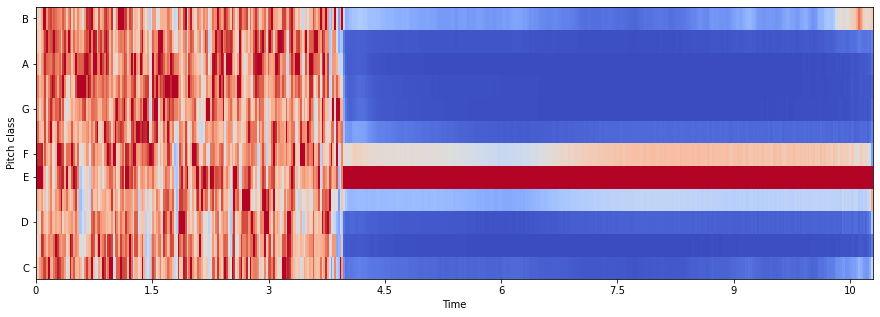

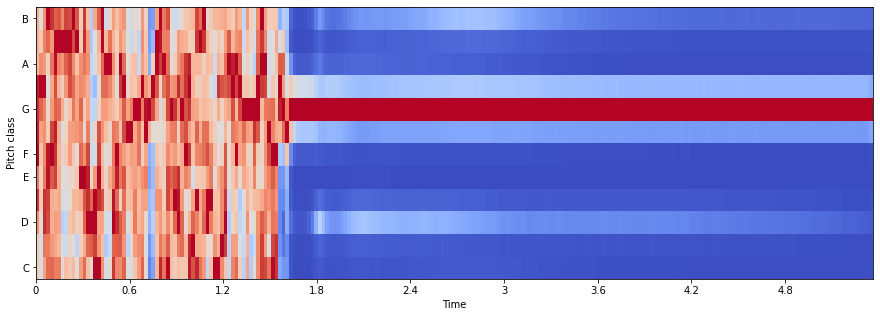

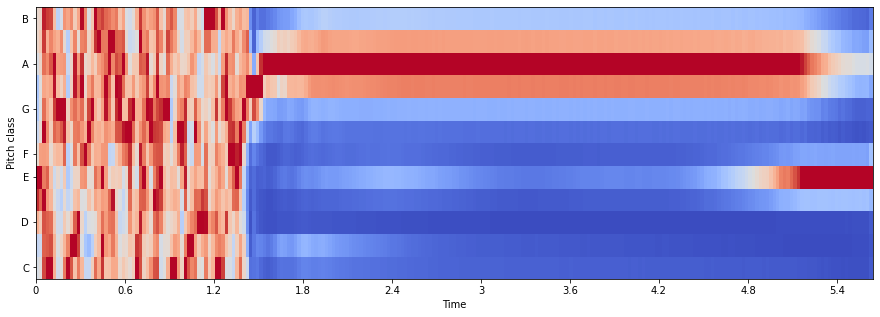

In [ ]:
import librosa.feature
#Audio 1
chromagram_1 = librosa.feature.chroma_stft(data_1)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram_1, x_axis='time', y_axis='chroma', cmap='coolwarm')

#Audio 2
chromagram_2 = librosa.feature.chroma_stft(data_2)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram_2, x_axis='time', y_axis='chroma', cmap='coolwarm')

#Audio 3
chromagram_3 = librosa.feature.chroma_stft(data_3)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram_3, x_axis='time', y_axis='chroma', cmap='coolwarm')

These diagrams confirm that the first audio is an E, the second a G, and the third one is an A, even if it gets the intensity of E at the end. This happens when we got two mixed signals and one is more predominant than the other (A in this case).

# Conclusion



In this notebook we have analysed some audio signals by using the Fourier transform, got the playing notes of the sounds and measured accuracy in cents. 

The idea of pipeline was to measure "energy" (area under peaks) and identify major note by peak with highest enerhy. Although signal 2 was more difficult to identify, the updated "energy" method with Fourier tranform has confirmed that the final notes for each audio are:

- Note E1, accuracy 0.338 cents
- Note G3, accuracy 7.613 cents
- Note A5, accuracy 0.6876 cents

Overall, we have researched the ways how to analyze audio signals with Fourier transform and create note detection algorithms.


# REFERENCES
[1] [Audio analysis with Python](https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html)

[2] [A Tutorial on Spectral Feature Extraction for Audio Analysis](https://analyticsindiamag.com/a-tutorial-on-spectral-feature-extraction-for-audio-analytics/)